In [73]:
import sys
sys.path.append('C:\\Users\\14761\\PycharmProjects\\untitled1\\venv\\Lib\\site-packages')

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

In [75]:
# 选股：SPY ENPH MA GILD JPM M
data = yf.download("SPY ENPH MA GILD JPM M", start="2020-10-28", end = "2022-10-28")
data = data['Adj Close']
# print(data)

data.head()

[*********************100%***********************]  6 of 6 completed


,ENPH,GILD,JPM,M,MA,SPY
Date,,,,,,
2020-10-28,102.809998,53.695747,91.293541,5.890335,288.268738,317.320679
2020-10-29,102.510002,53.521999,91.889297,5.977098,290.049469,320.545776
2020-10-30,98.089996,53.174519,92.712021,5.986739,285.557953,317.204163
2020-11-02,103.830002,53.521999,94.801926,5.861413,286.873749,320.759491
2020-11-03,104.750000,53.796337,97.790199,6.353077,292.235931,326.422791


Text(0,0.5,'price in $')

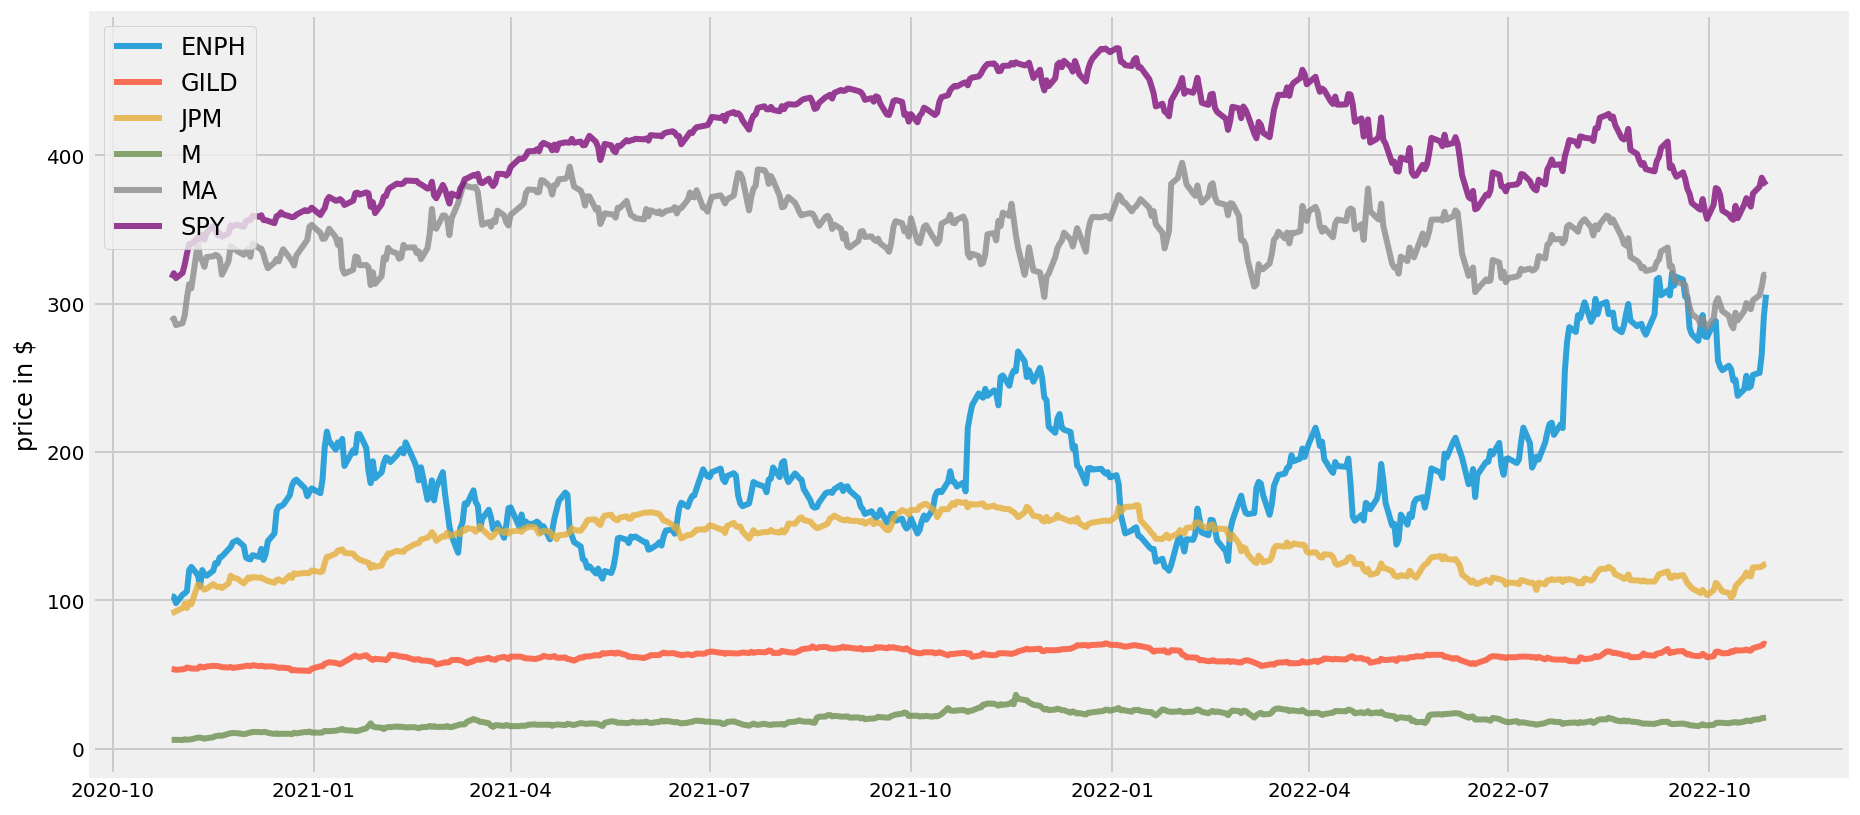

In [76]:
# price change
plt.figure(figsize=(14, 7))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')


Text(0,0.5,'daily returns')

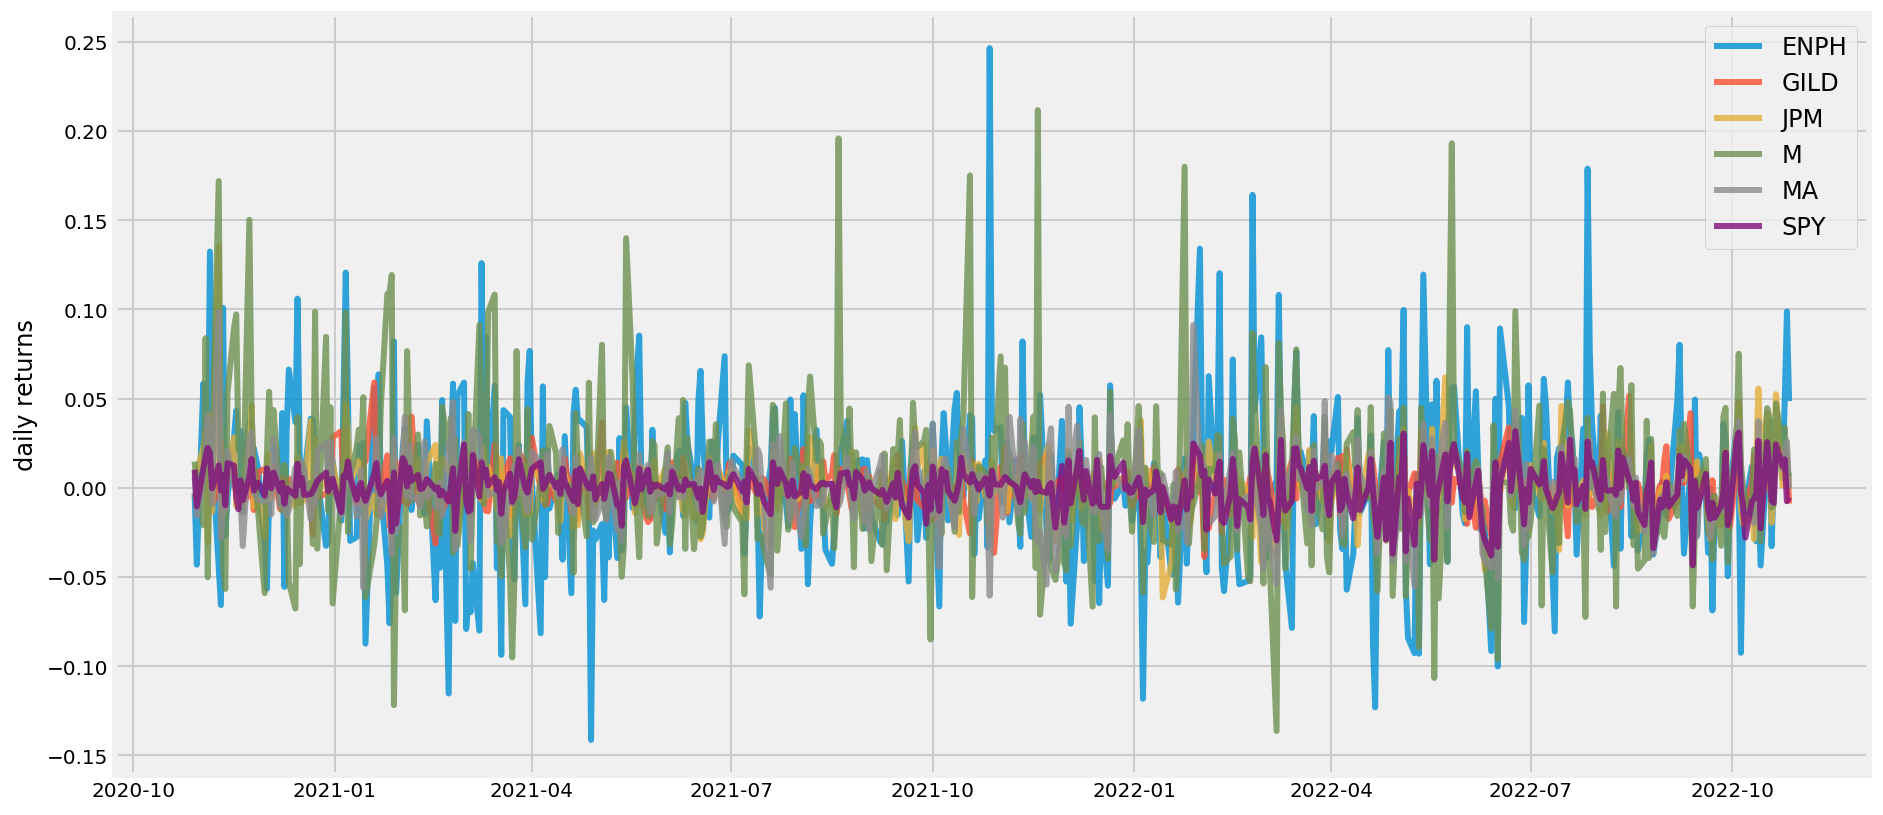

In [77]:
# return changes
returns = data.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')


In [78]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [79]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((5,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

ENPH    0.003151
GILD    0.000615
JPM     0.000775
M       0.003452
MA      0.000391
SPY     0.000427
dtype: float64
          ENPH      GILD       JPM         M        MA       SPY
ENPH  0.001990  0.000022  0.000109  0.000403  0.000195  0.000246
GILD  0.000022  0.000166  0.000058  0.000053  0.000057  0.000060
JPM   0.000109  0.000058  0.000317  0.000338  0.000175  0.000128
M     0.000403  0.000053  0.000338  0.001912  0.000252  0.000219
MA    0.000195  0.000057  0.000175  0.000252  0.000376  0.000159
SPY   0.000246  0.000060  0.000128  0.000219  0.000159  0.000138


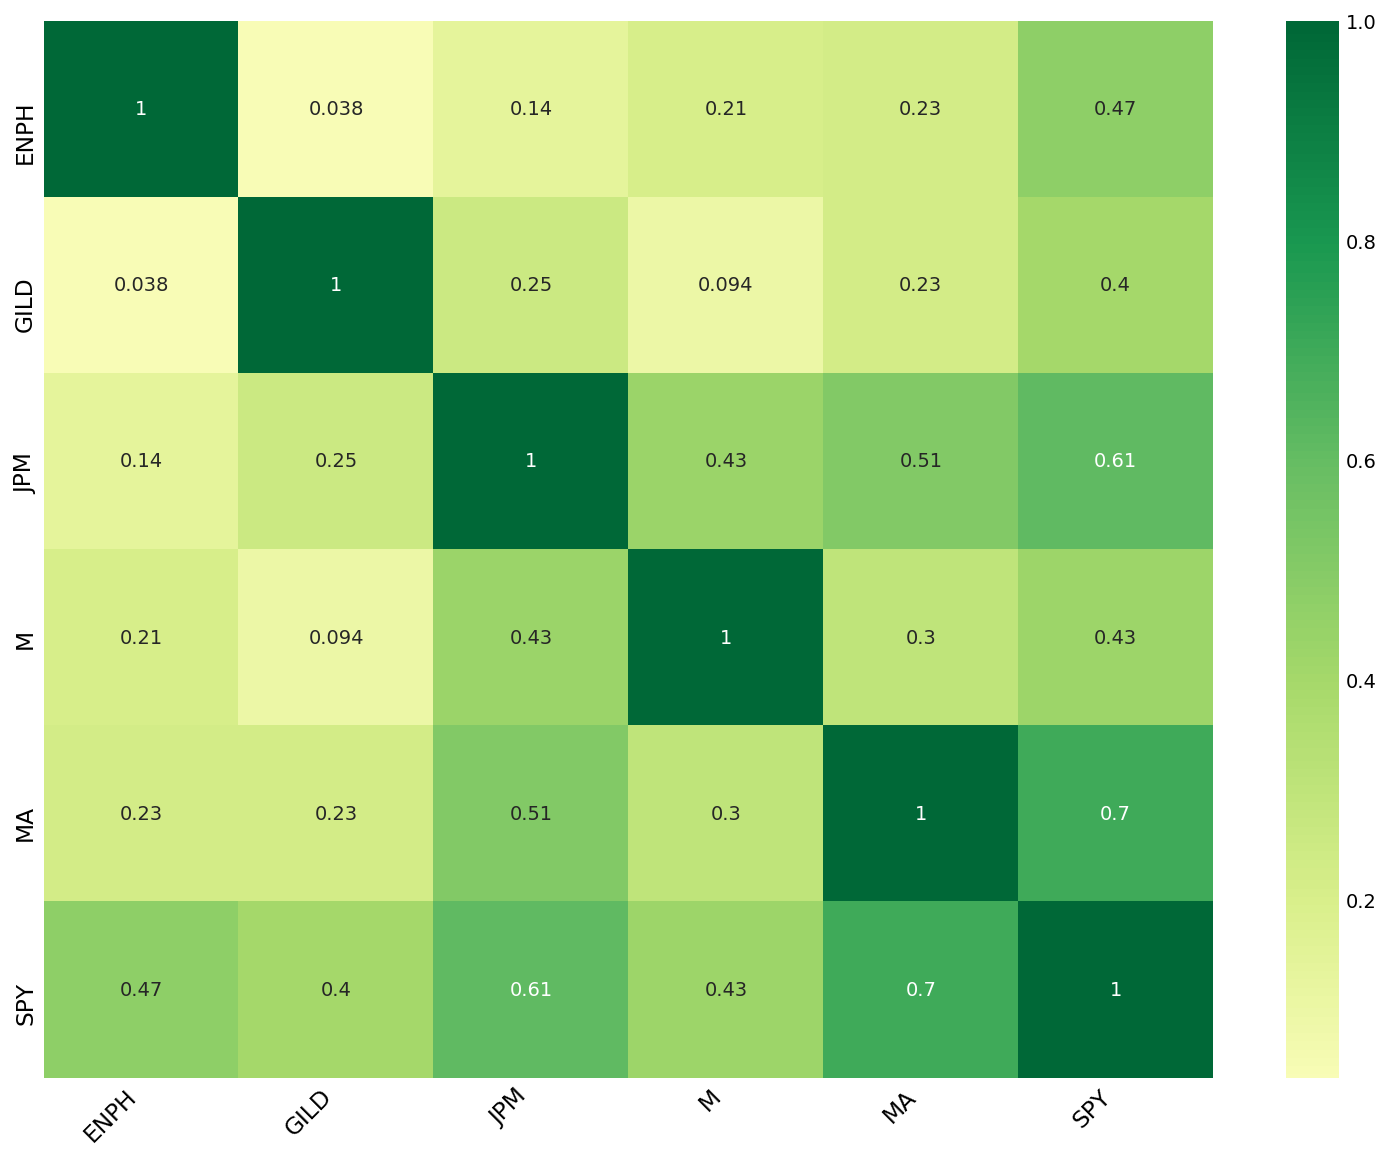

In [97]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.042
print(mean_returns)
print(cov_matrix)

#绘制图像
plt.figure(figsize=(12,10), dpi= 70)
sns.heatmap(returns.corr() #需要输入的相关性矩阵
            , cmap='RdYlGn' #使用的光谱，一般来说都会使用由浅至深，或两头颜色差距较大的光谱
            , center=0 #填写数据的中值，注意观察此时的颜色条，大于0的是越来越靠近绿色，小于0的越来越靠近红色
         #   , center= -1 #填写数据中的最大值/最小值，则最大值/最小值是最浅或最深的颜色，数据离该极值越远，颜色越浅/颜色越深
            , annot=True
           )

#装饰图像
# plt.title('mtcars数据集的相关性矩阵', fontsize=22)
plt.xticks(fontsize=12 #字体大小
           ,rotation=45 #字体是否进行旋转
           ,horizontalalignment='right' #刻度的相对位置
          )
plt.yticks(fontsize=12)
plt.show()


In [81]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.51
Annualised Volatility: 0.31


             ENPH   GILD   JPM      M    MA   SPY
allocation  26.08  41.88  2.27  26.27  1.35  2.15
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.14
Annualised Volatility: 0.17


            ENPH   GILD   JPM     M     MA    SPY
allocation  0.54  37.18  9.99  0.45  10.29  41.56


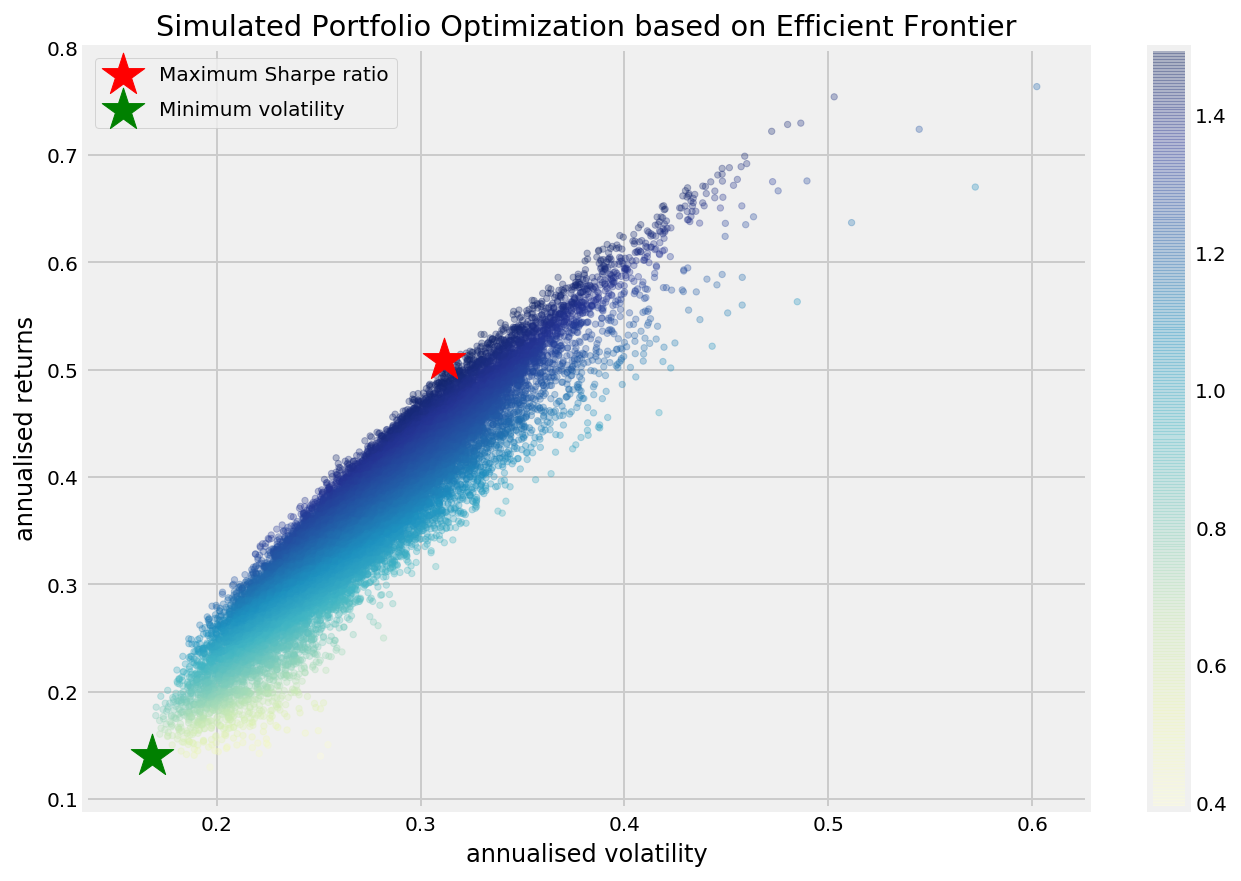

In [82]:
# 基于 monte carlo 模拟（无计算）得到的 portfolios return & volatility 情况
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [83]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [84]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [85]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
   
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [86]:
# 可以根据收益率（纵轴）调target，efficient frontier

In [87]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.7, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.53
Annualised Volatility: 0.32


             ENPH   GILD  JPM      M   MA  SPY
allocation  25.35  44.69  0.0  29.96  0.0  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.16


            ENPH   GILD   JPM    M   MA    SPY
allocation   0.0  42.11  3.26  0.0  0.0  54.64


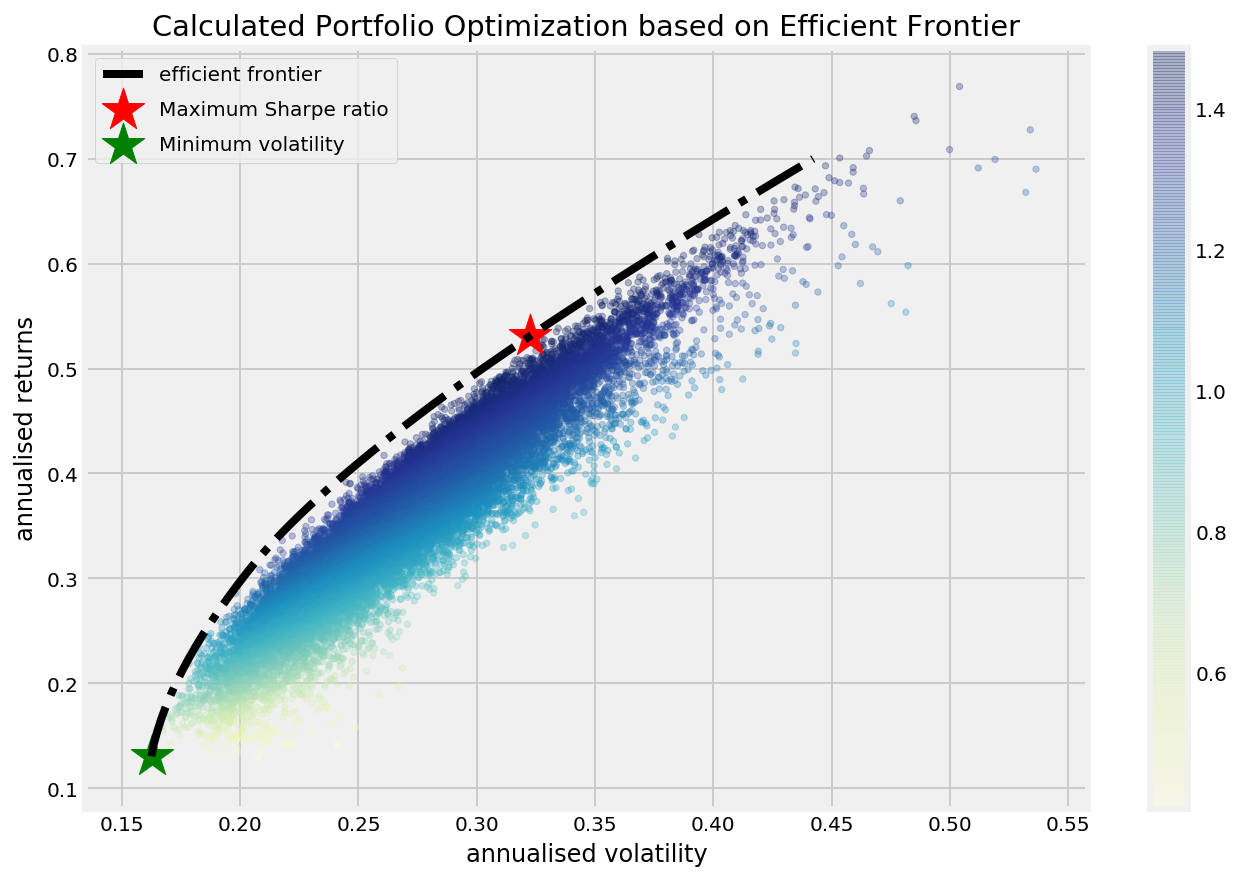

In [88]:
# 基于MPT理论计算得到的efficient frontier和Max Sharpe Ratio portfolio
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [89]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(data.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.875, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.53
Annualised Volatility: 0.32


             ENPH   GILD  JPM      M   MA  SPY
allocation  25.35  44.69  0.0  29.96  0.0  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.16


            ENPH   GILD   JPM    M   MA    SPY
allocation   0.0  42.11  3.26  0.0  0.0  54.64
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

ENPH : annuaised return 0.79 , annualised volatility: 0.71
GILD : annuaised return 0.16 , annualised volatility: 0.2
JPM : annuaised return 0.2 , annualised volatility: 0.28
M : annuaised return 0.87 , annualised volatility: 0.69
MA : annuaised return 0.1 , annualised volatility: 0.31
SPY : annuaised return 0.11 , annualised volatilit

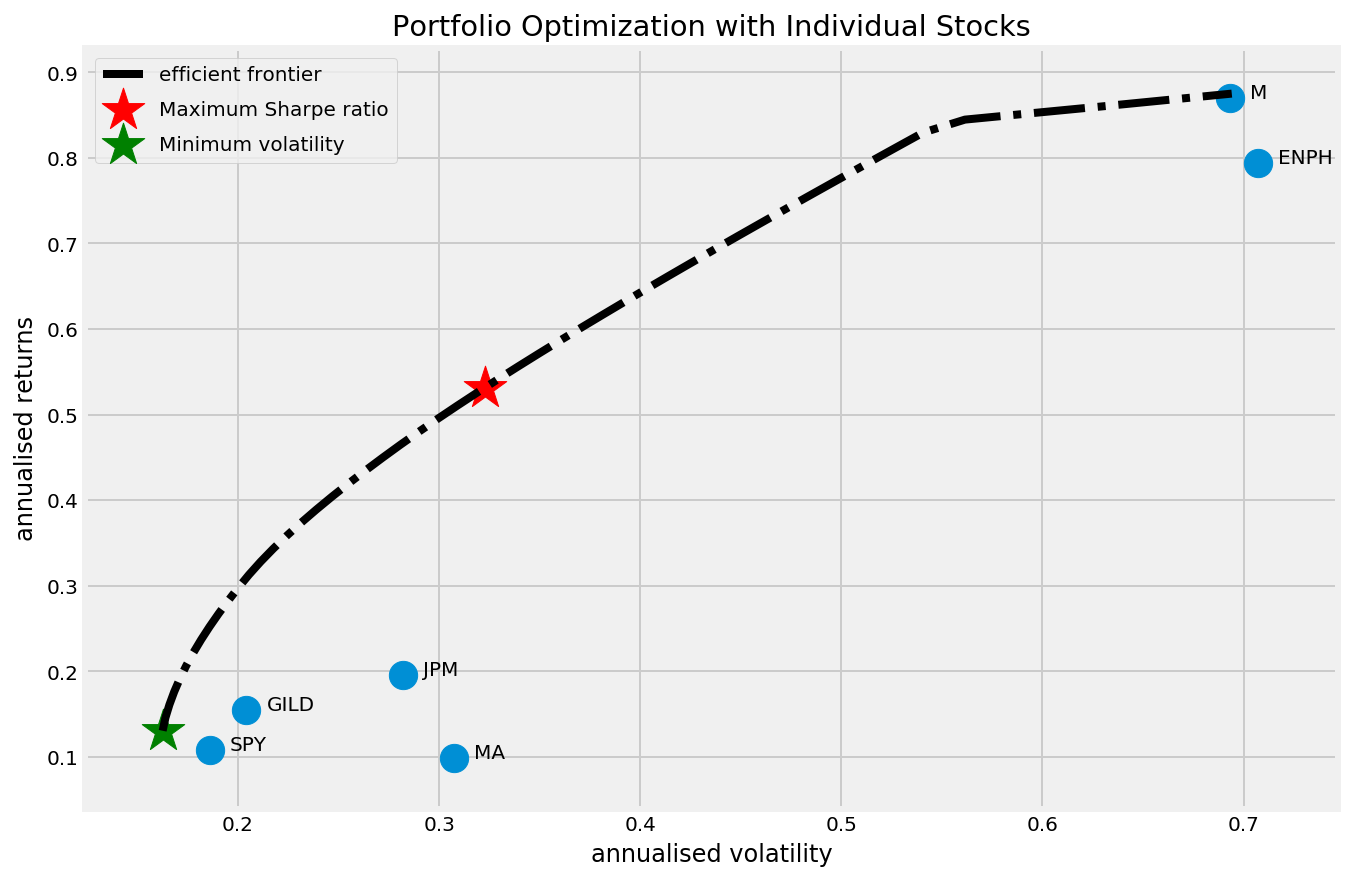

In [90]:
# efficient frontier + 个股表现
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)